In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os, sys
from pathlib import Path
import xarray as xr
from helpers.delphi_epidata import Epidata
import epiweeks
import data_utils

In [2]:
flusetup = data_utils.FluSetup.from_flusight(flu_season_start_date=pd.to_datetime("2020-12-15"))

Spatial Setup with 53 locations.


## Dataset format for my class:
The dataset is a xarray object stored as netcdf on disk. It has dimensions `(sample, feature, date, place)` where date and place are padded to have dimension 64.
- dates are Saturdays
- places are location from Flusight data locations
- samples are integers


## FluSight dataset (= Ground-truth data)

Make sure my fork is synced, then
```bash
./update_data.sh
```
Locations are always ordered like this dataframe:

In [3]:
flusight = data_utils.get_from_epidata(dataset="flusight", flusetup=flusetup, write=False)
#flusight = flusight[flusight['location'].isin(flusight_locations['location_code'])]

/!\ Make sure ./update_data.sh is ran AND that the fork is updated


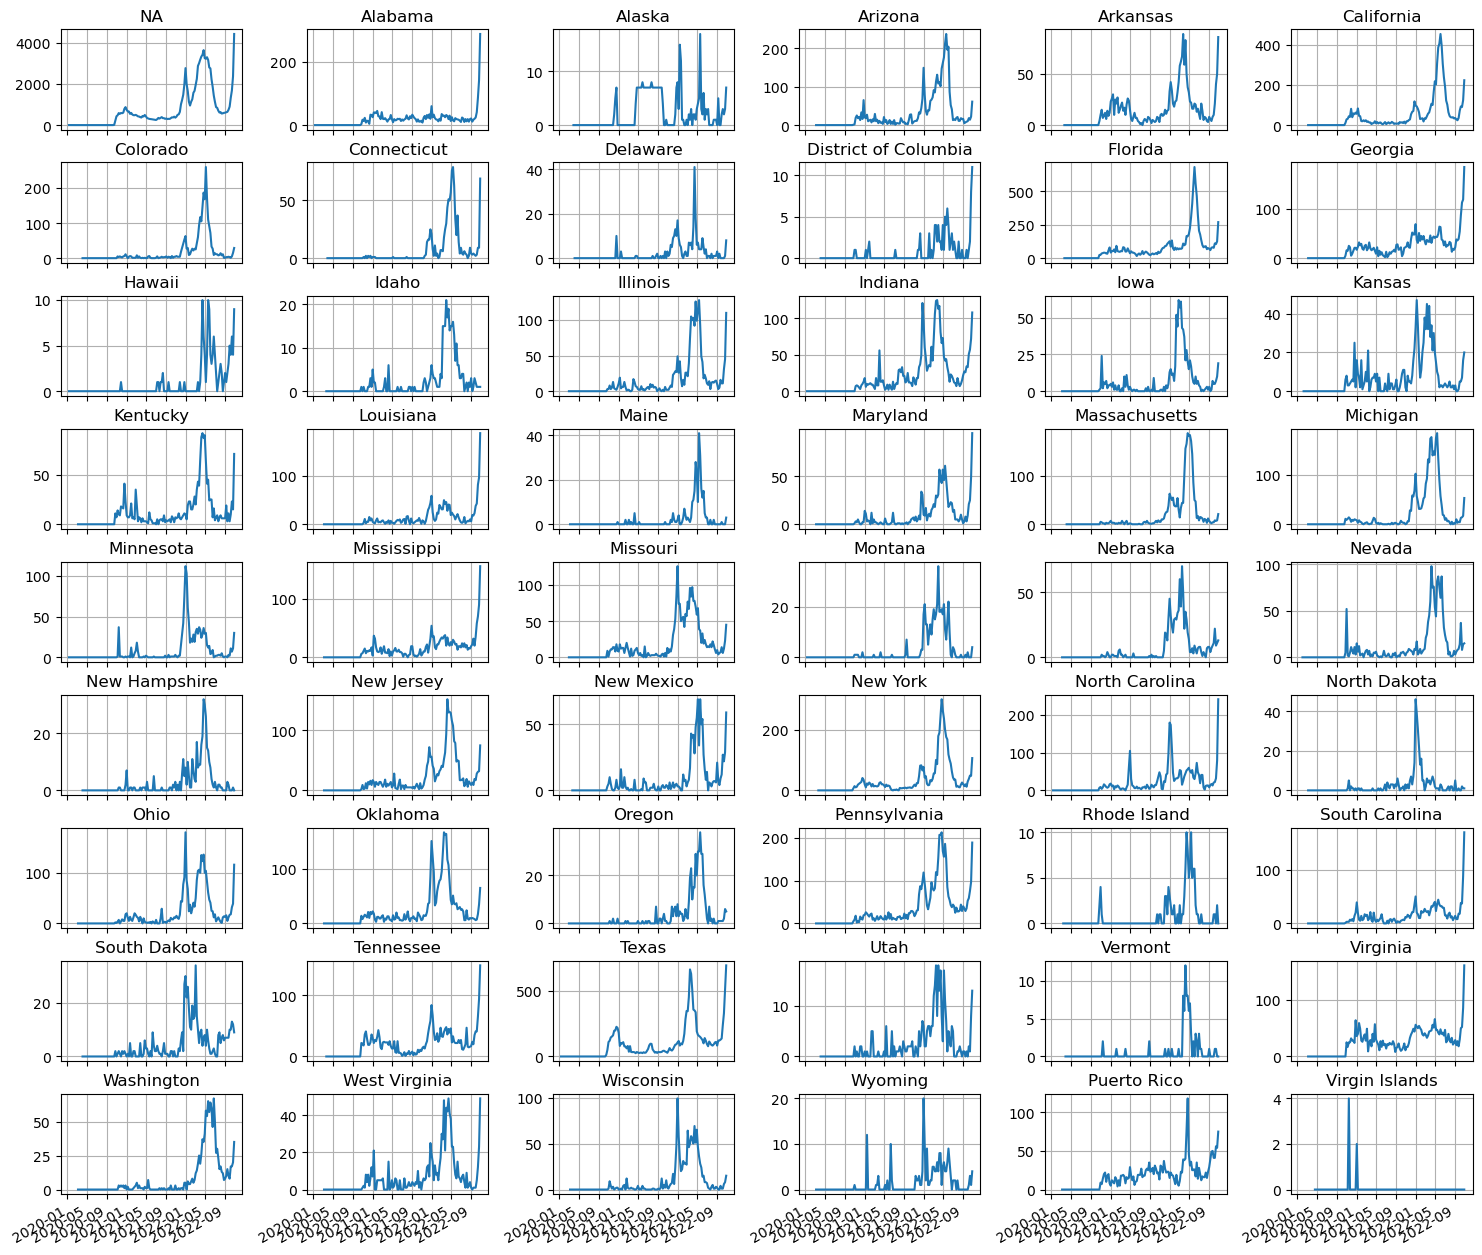

In [4]:
fig, axes = plt.subplots(9, 6, sharex=True, figsize=(15,15))
flusight_piv  = flusight.pivot(index = "week_enddate", columns='location_code', values='value')
for idx, pl in enumerate(flusight_piv.columns):
    ax = axes.flat[idx]
    ax.plot(flusight_piv[pl])
    ax.set_title(flusetup.get_location_name(pl))
    ax.grid()
fig.tight_layout()
fig.autofmt_xdate()

In [5]:
# padded dataset for inpatient beds
df = flusight.reset_index()
df = df[df["fluseason"] == 2021]
df

,index,location,location_name_x,value,week_enddate,abbreviation,location_name_y,population,geoid,location_code,fluseason,fluseason_fraction
5042,5042,02,Alaska,2,2021-12-18,AK,Alaska,731545.0,02000,02,2021,0.005479
5043,5043,01,Alabama,34,2021-12-18,AL,Alabama,4903185.0,01000,01,2021,0.005479
5044,5044,05,Arkansas,14,2021-12-18,AR,Arkansas,3017804.0,05000,05,2021,0.005479
5045,5045,04,Arizona,44,2021-12-18,AZ,Arizona,7278717.0,04000,04,2021,0.005479
5046,5046,06,California,70,2021-12-18,CA,California,39512223.0,06000,06,2021,0.005479
...,...,...,...,...,...,...,...,...,...,...,...,...
7521,7521,50,Vermont,0,2022-10-29,VT,Vermont,623989.0,50000,50,2021,0.868493
7522,7522,53,Washington,35,2022-10-29,WA,Washington,7614893.0,53000,53,2021,0.868493
7523,7523,55,Wisconsin,15,2022-10-29,WI,Wisconsin,5822434.0,55000,55,2021,0.868493
7524,7524,54,West Virginia,49,2022-10-29,WV,West Virginia,1792147.0,54000,54,2021,0.868493


In [6]:
gt_xarr = data_utils.dataframe_to_xarray(df, flusetup=flusetup, 
            xarray_name = "gt_flusight_incidHosp", 
            xarrax_features = "incidHosp")
print(gt_xarr.shape)
gt_xarr.to_netcdf(f"datasets/{gt_xarr.name}_padded.nc")

(1, 64, 64)


This data is on saturday for 53 locations + US

In [7]:
download=True

## Delphi-epidata Flusurv

In [8]:
flusurv = data_utils.get_from_epidata(dataset="flusurv", flusetup=flusetup, download=download)
flusurv.columns

>> CA           1, success, with  518 data points from 200340 to 202017
>> CO           1, success, with  518 data points from 200340 to 202017
>> CT           1, success, with  518 data points from 200340 to 202017
>> GA           1, success, with  518 data points from 200340 to 202017
>> IA           1, success, with   65 data points from 200935 to 201317
>> ID           1, success, with   65 data points from 200935 to 201117
>> MD           1, success, with  518 data points from 200340 to 202017
>> MI           1, success, with  336 data points from 200935 to 202017
>> MN           1, success, with  518 data points from 200340 to 202017
>> NM           1, success, with  487 data points from 200440 to 202017
>> NY_albany    1, success, with  518 data points from 200340 to 202017
>> NY_rochester 1, success, with  518 data points from 200340 to 202017
>> OH           1, success, with  301 data points from 201040 to 202017
>> OK           1, success, with   65 data points from 200935 to

Index(['release_date', 'location', 'issue', 'epiweek', 'lag', 'rate_age_0',
       'rate_age_1', 'rate_age_2', 'rate_age_3', 'rate_age_4', 'rate_overall',
       'week_enddate', 'abbreviation', 'location_name', 'population', 'geoid',
       'location_code', 'value', 'fluseason', 'fluseason_fraction'],
      dtype='object')

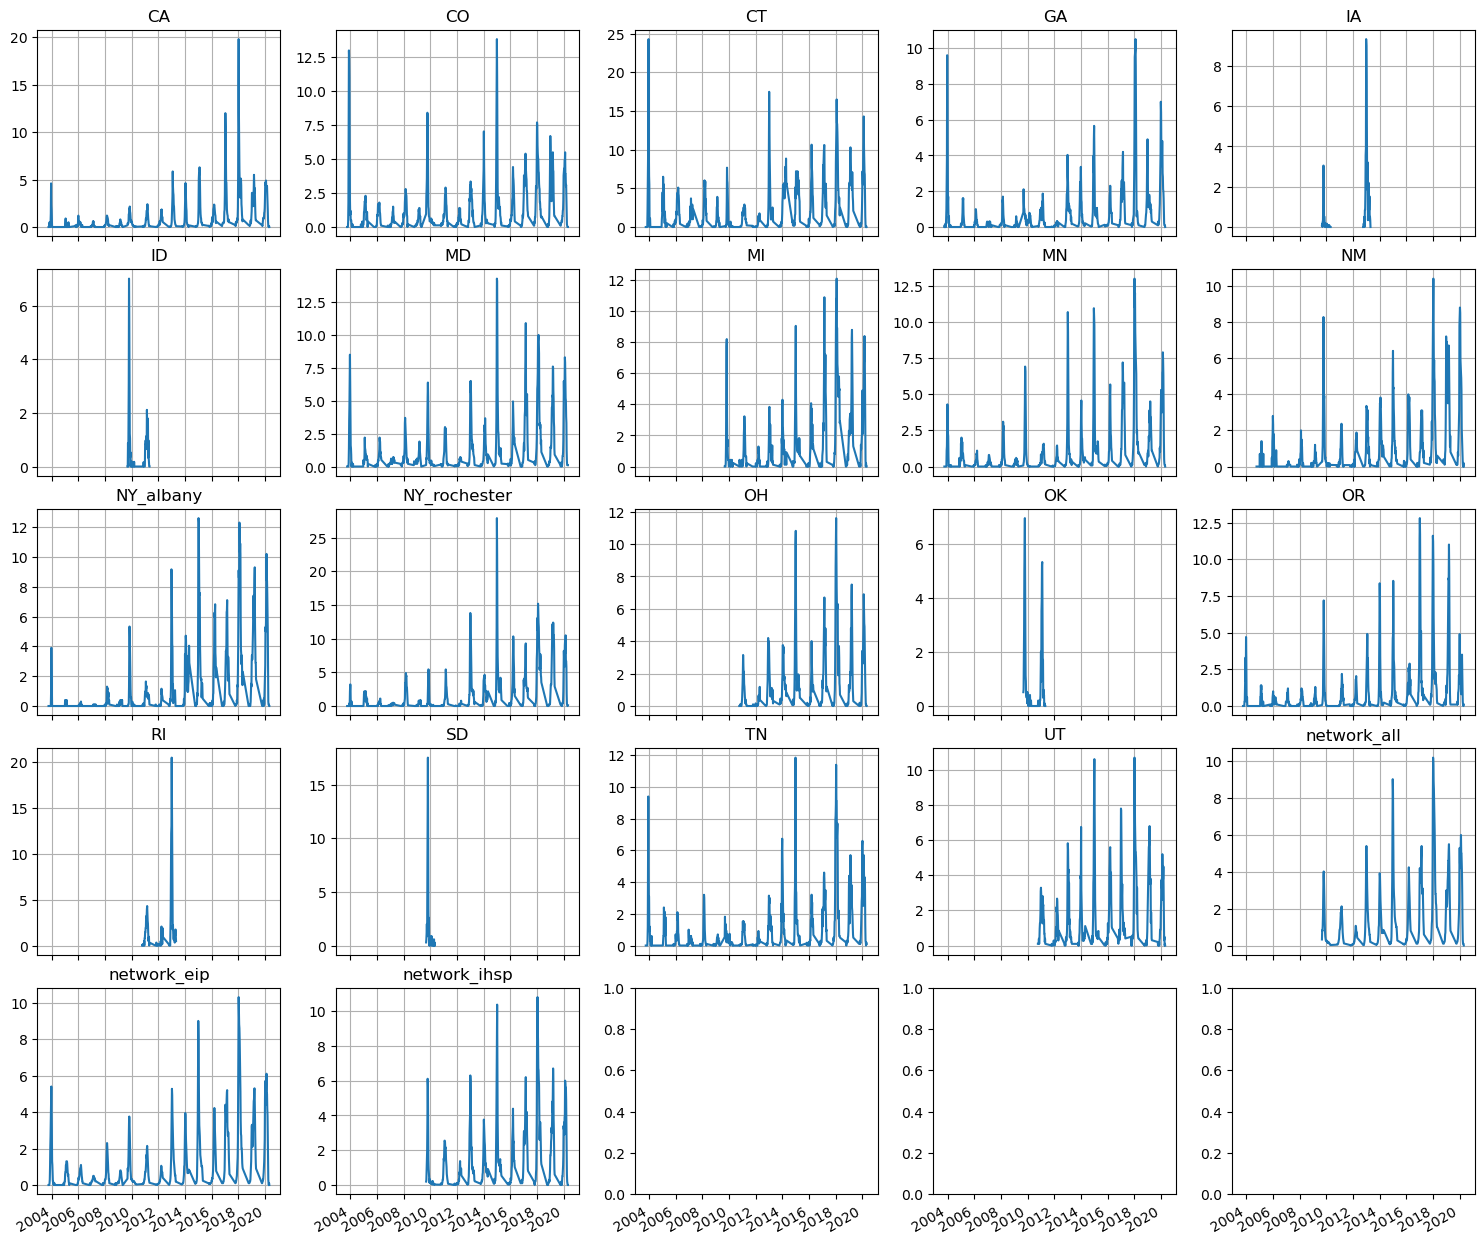

In [9]:
fig, axes = plt.subplots(5, 5, sharex=True, figsize=(15,15))
flusurv_piv  = flusurv.pivot(columns='location', values='rate_overall', index="week_enddate")
for idx, pl in enumerate(data_utils.get_all_locations("flusurv")):
    ax = axes.flat[idx]
    ax.plot(flusurv_piv[pl])
    ax.set_title(pl)
    ax.grid()
fig.tight_layout()
fig.autofmt_xdate()

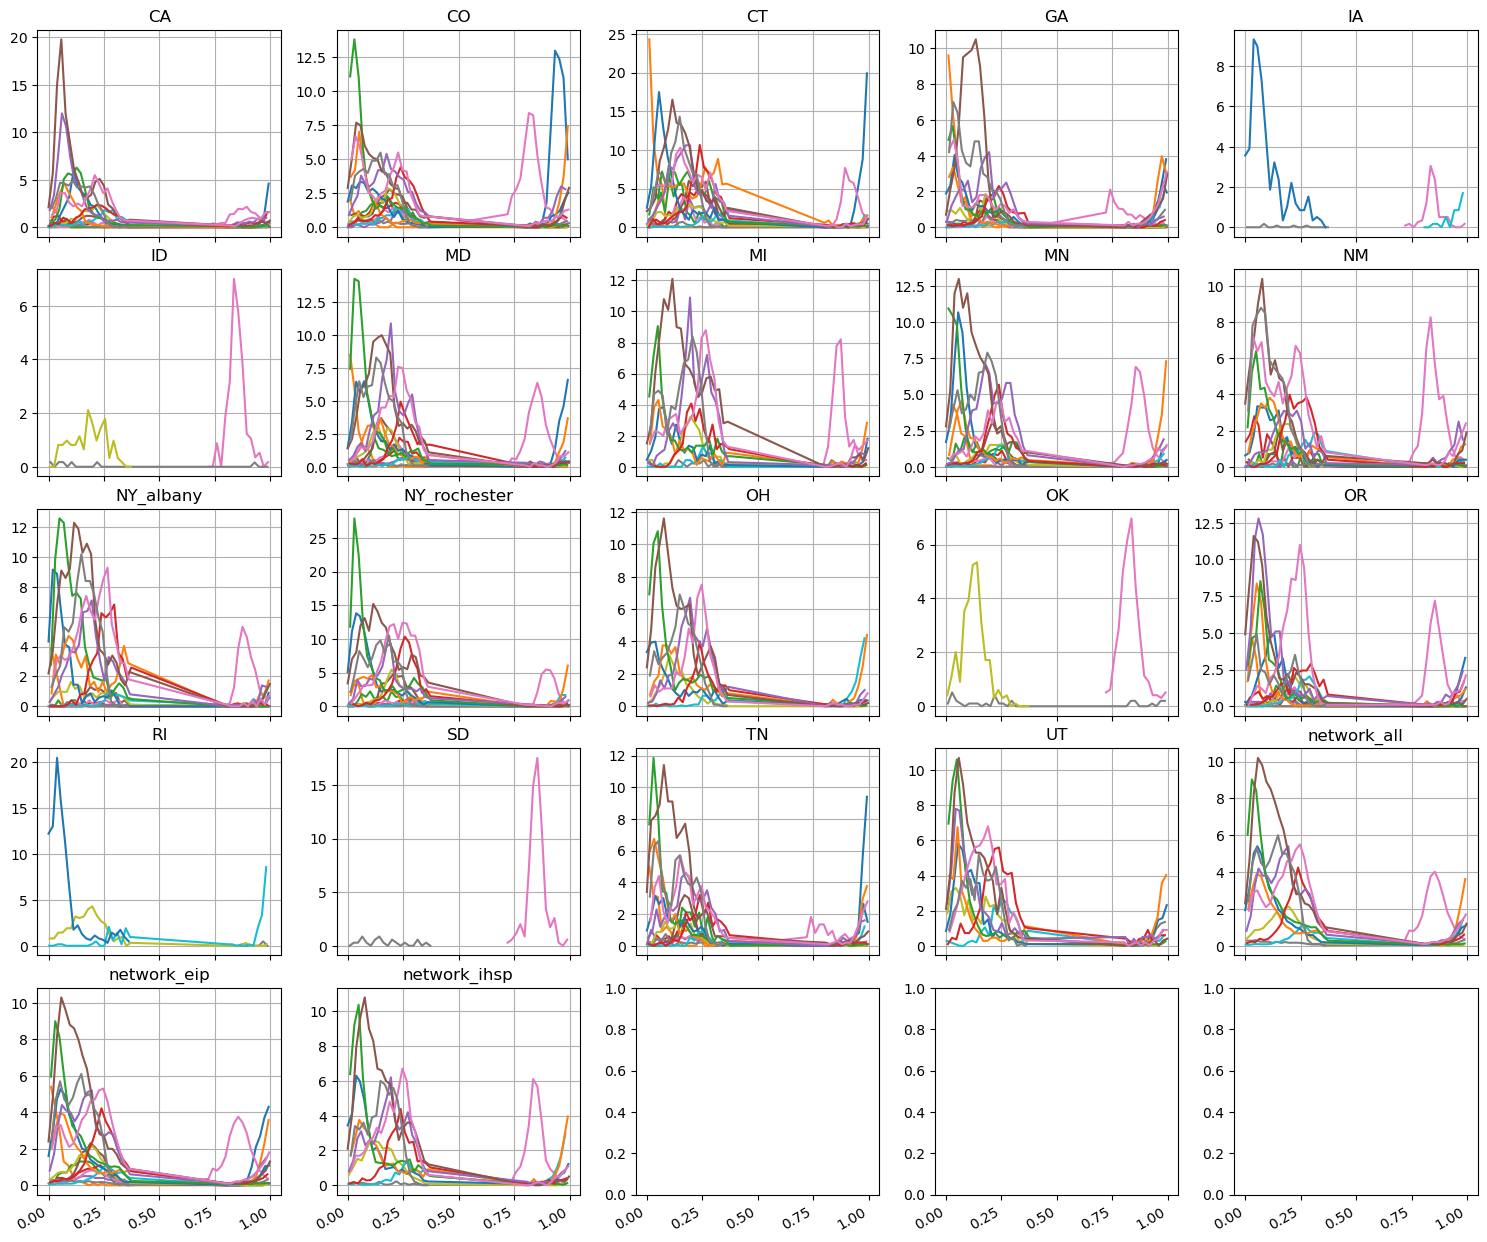

In [10]:
fig, axes = plt.subplots(5, 5, sharex=True, figsize=(15,15))
flusurv_piv = flusurv.pivot(columns='location', values='rate_overall', index=["fluseason", "fluseason_fraction"])
for idx, pl in enumerate(data_utils.get_all_locations("flusurv")):
    for year in flusurv_piv.index.unique(level='fluseason'):
        ax = axes.flat[idx]
        ax.plot(flusurv_piv.loc[year, pl])
        ax.set_title(pl)
    ax.grid()
fig.tight_layout()
fig.autofmt_xdate()

## Epidata Fluview
There is also [fluview clinical](https://cmu-delphi.github.io/delphi-epidata/api/fluview_clinical.html) for FluA, FluB, and tested specimen. Which quantity should I look for in this dataset ?

In [11]:
fluview = data_utils.get_from_epidata(dataset="fluview", flusetup=flusetup, download=download)
fluview

>> nat          1, success, with 1206 data points from 199740 to 202235
>> hhs1         1, success, with 1206 data points from 199740 to 202235
>> hhs2         1, success, with 1206 data points from 199740 to 202235
>> hhs3         1, success, with 1206 data points from 199740 to 202235
>> hhs4         1, success, with 1206 data points from 199740 to 202235
>> hhs5         1, success, with 1206 data points from 199740 to 202235
>> hhs6         1, success, with 1206 data points from 199740 to 202235
>> hhs7         1, success, with 1206 data points from 199740 to 202235
>> hhs8         1, success, with 1206 data points from 199740 to 202235
>> hhs9         1, success, with 1206 data points from 199740 to 202235
>> hhs10        1, success, with 1206 data points from 199740 to 202235
>> cen1         1, success, with 1206 data points from 199740 to 202235
>> cen2         1, success, with 1206 data points from 199740 to 202235
>> cen3         1, success, with 1206 data points from 199740 to

,release_date,region,issue,epiweek,lag,num_ili,num_patients,num_providers,num_age_0,num_age_1,...,ili,week_enddate,abbreviation,location_name,population,geoid,location_code,value,fluseason,fluseason_fraction
0,2013-12-31,nat,201352,199740,847,570,46842,192,179,205,...,1.216857,1997-10-04,NaN,NaN,NaN,NaN,NaN,1.216857,1996,0.800000
1,2013-12-31,nat,201352,199741,846,615,48023,191,199,242,...,1.280636,1997-10-11,NaN,NaN,NaN,NaN,NaN,1.280636,1996,0.819178
2,2013-12-31,nat,201352,199742,845,681,54961,219,228,266,...,1.239060,1997-10-18,NaN,NaN,NaN,NaN,NaN,1.239060,1996,0.838356
3,2013-12-31,nat,201352,199743,844,653,57044,213,188,236,...,1.144730,1997-10-25,NaN,NaN,NaN,NaN,NaN,1.144730,1996,0.857534
4,2013-12-31,nat,201352,199744,843,700,55506,213,217,280,...,1.261125,1997-11-01,NaN,NaN,NaN,NaN,NaN,1.261125,1996,0.876712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56398,2022-09-09,jfk,202235,202231,4,1517,79616,26,None,None,...,1.905400,2022-08-06,NY,New York,19453561.0,36000,36,1.905400,2021,0.638356
56399,2022-09-09,jfk,202235,202232,3,1377,78674,26,None,None,...,1.750260,2022-08-13,NY,New York,19453561.0,36000,36,1.750260,2021,0.657534
56400,2022-09-09,jfk,202235,202233,2,1384,76378,25,None,None,...,1.812040,2022-08-20,NY,New York,19453561.0,36000,36,1.812040,2021,0.676712
56401,2022-09-09,jfk,202235,202234,1,1227,76349,24,None,None,...,1.607090,2022-08-27,NY,New York,19453561.0,36000,36,1.607090,2021,0.695890


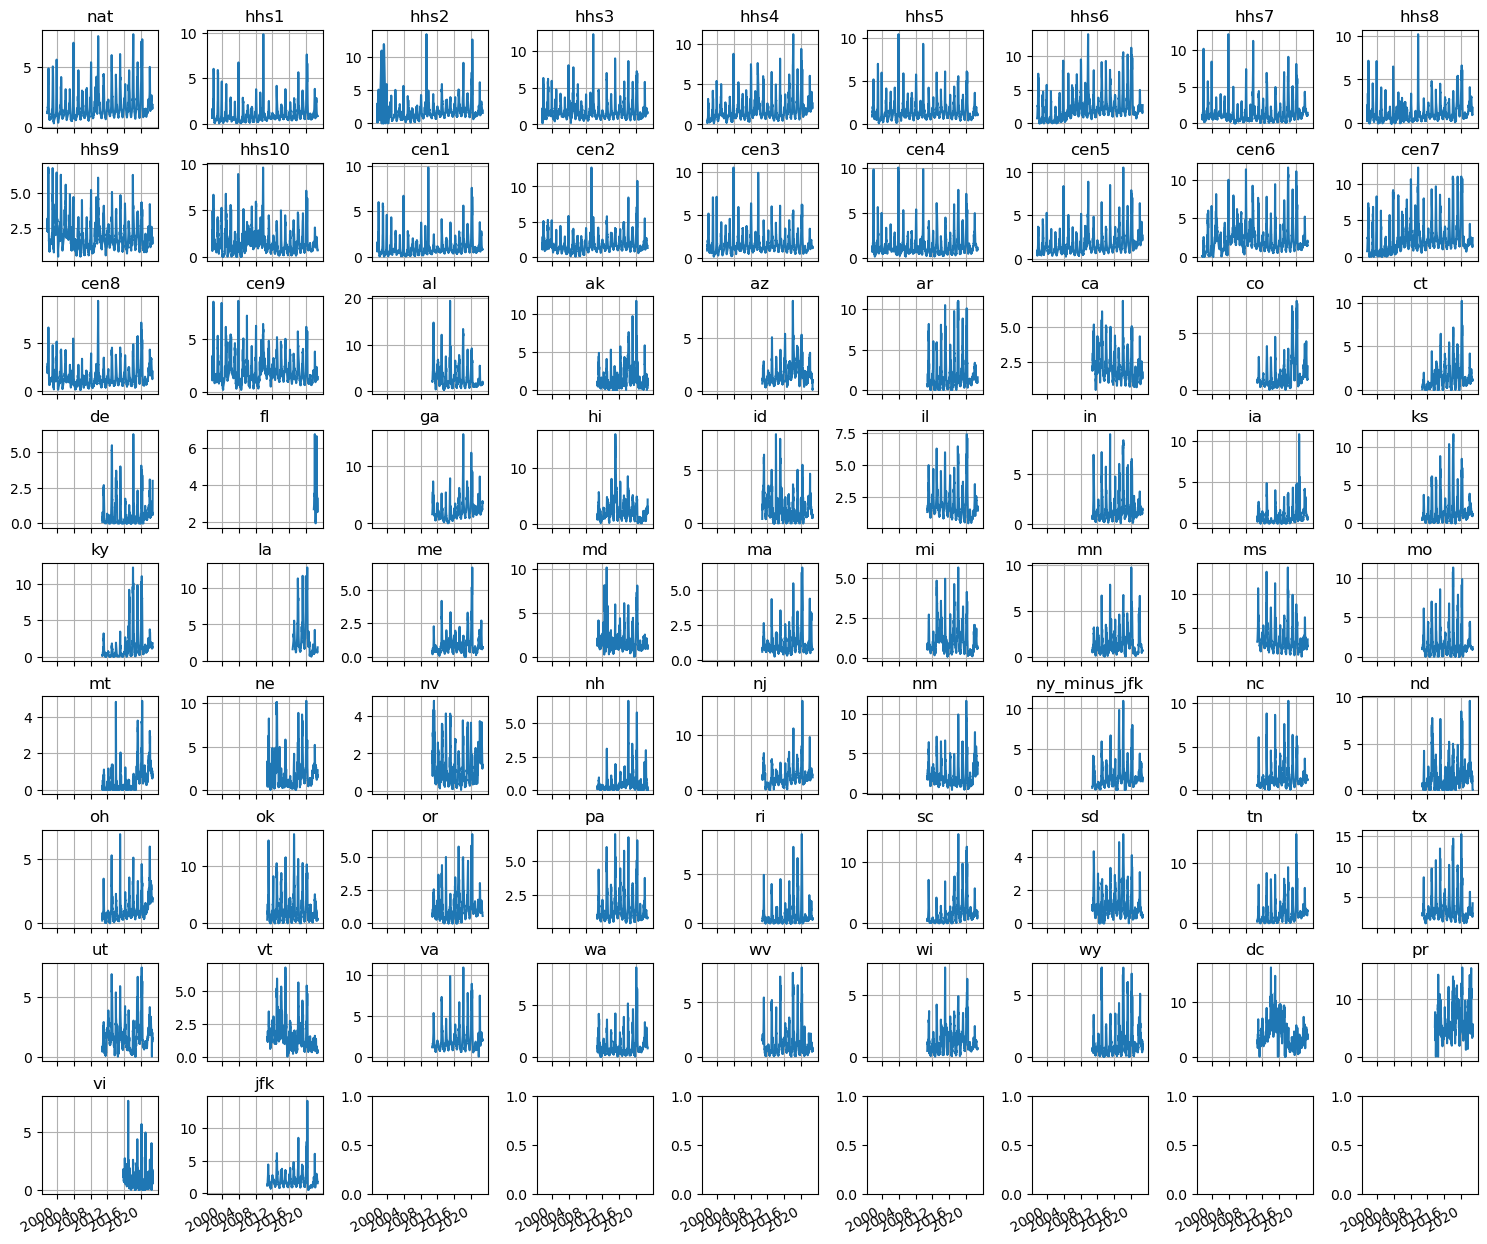

In [12]:
fig, axes = plt.subplots(9, 9, sharex=True, figsize=(15,15))

fluview_piv  = fluview.pivot(columns='region', values='ili', index="week_enddate")
for idx, pl in enumerate(fluview["region"].unique()):
    ax = axes.flat[idx]
    ax.plot(fluview_piv[pl])
    ax.set_title(pl)#get_location_name(pl))
    ax.grid()
fig.tight_layout()
fig.autofmt_xdate()

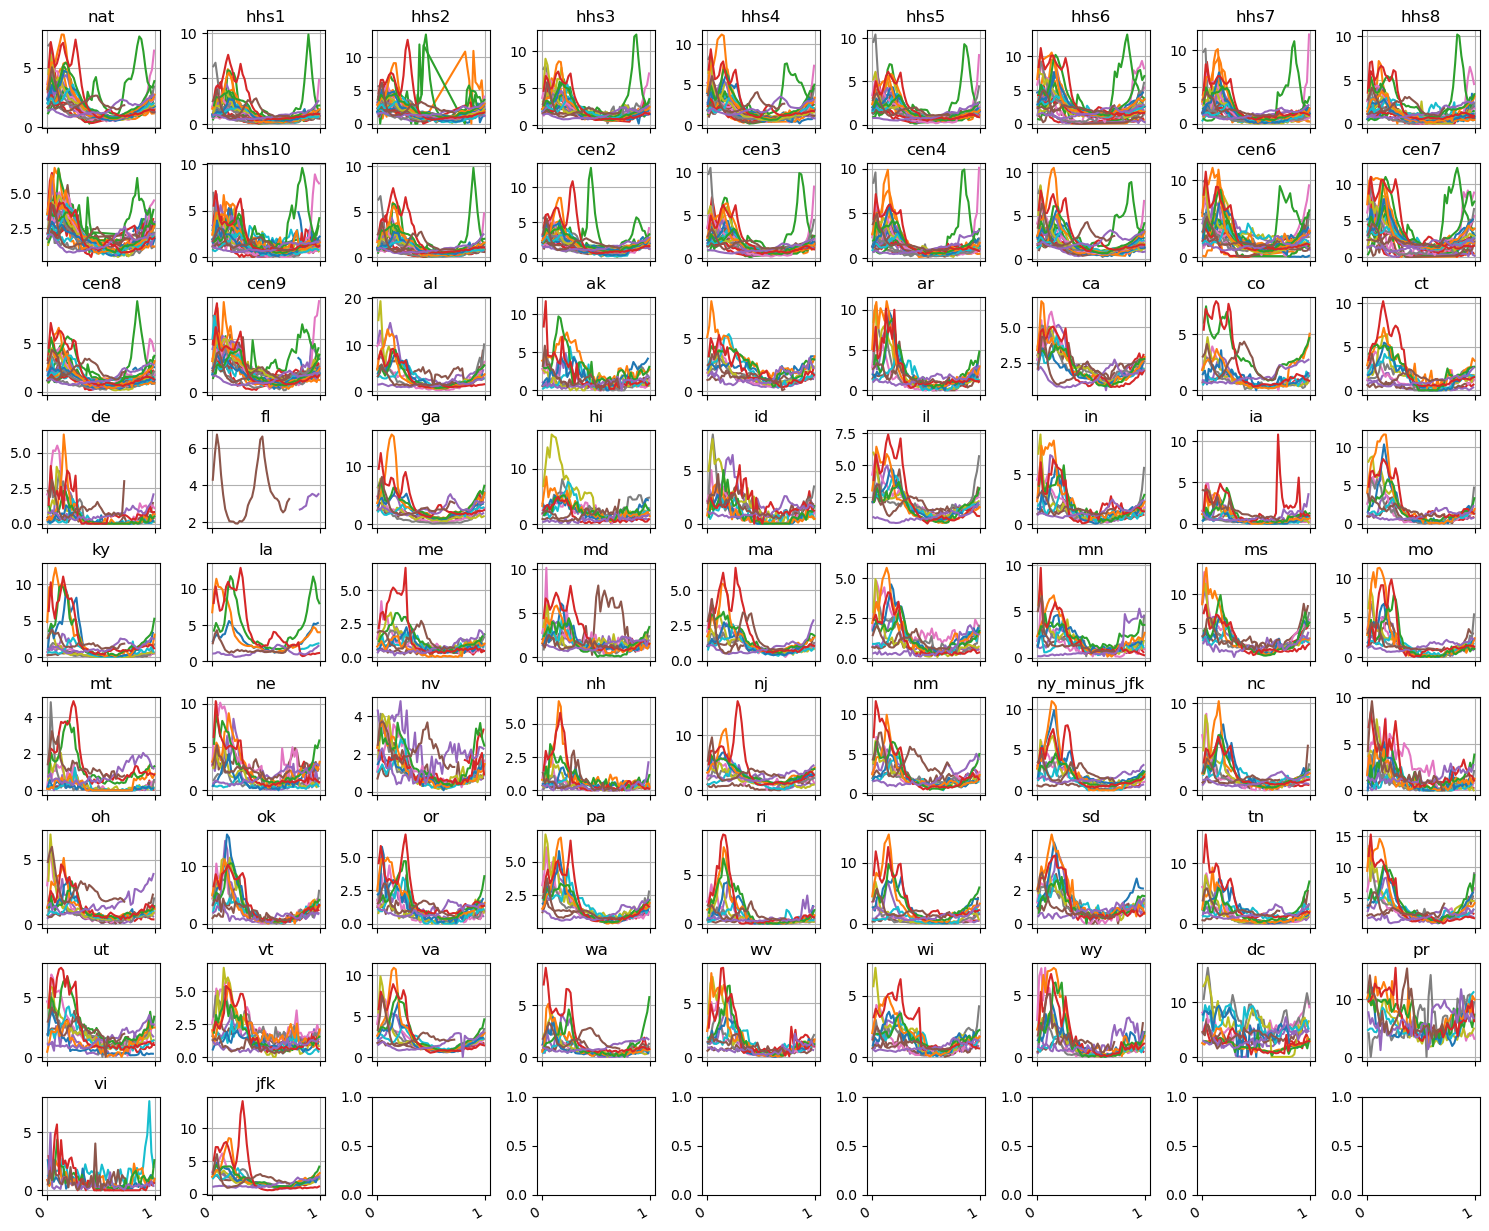

In [13]:
fig, axes = plt.subplots(9, 9, sharex=True, figsize=(15,15))
fluview_piv = fluview.pivot(columns='region', values='ili', index=["fluseason", "fluseason_fraction"])
for idx, pl in enumerate(fluview["region"].unique()):
    for year in fluview_piv.index.unique(level='fluseason'):
        ax = axes.flat[idx]
        ax.plot(fluview_piv.loc[year, pl])
        ax.set_title(pl)
    ax.grid()
fig.tight_layout()
fig.autofmt_xdate()

## Merge datasets

In [14]:
for locations_code in flusetup.locations_df.location_code:
    in_fluview, in_flusruv = False, False
    if not flusurv[flusurv['location_code'] == locations_code].empty:
        in_flusruv = True
    if not fluview[fluview['location_code'] == locations_code].empty:
        in_fluview = True
    if in_fluview and in_flusruv:
        suffix = "in both fluview and flusurv"
    elif in_fluview:
        suffix = "in fluview"
    elif in_flusruv:
        suffix = " in flusurv"
    else:
        suffix = "NOT in fluview NOR flusurv"
    print(f"{locations_code}, {flusetup.get_location_name(locations_code):<22} {suffix}")

01, Alabama                in fluview
02, Alaska                 in fluview
04, Arizona                in fluview
05, Arkansas               in fluview
06, California             in both fluview and flusurv
08, Colorado               in both fluview and flusurv
09, Connecticut            in both fluview and flusurv
10, Delaware               in fluview
11, District of Columbia   in fluview
12, Florida                in fluview
13, Georgia                in both fluview and flusurv
15, Hawaii                 in fluview
16, Idaho                  in both fluview and flusurv
17, Illinois               in fluview
18, Indiana                in fluview
19, Iowa                   in both fluview and flusurv
20, Kansas                 in fluview
21, Kentucky               in fluview
22, Louisiana              in fluview
23, Maine                  in fluview
24, Maryland               in both fluview and flusurv
25, Massachusetts          in fluview
26, Michigan               in both fluview an

##  FluSurv from Claire
(min and max from Flu SMH comes from these):
the numbers come from FluSurvNet -- hosp rates taken and multiplied by population
```
[9:49 AM] Prior Peaks: are based on the minimum and maximum observed in national data in the 8 pre-pandemic seasons 2012-2020, converted to state-level estimates.
The estimates for incident are based on weekly peaks, and for cumulative based on cumulative hospitalizations at the end of the season.
```

So on R you do:
```R
source("~/Documents/phd/COVIDScenarioPipeline/Flu_USA/R/groundtruth_functions.R")
flus_surv <- get_flu_groundtruth(source="flusurv_hosp", "2015-10-10", "2022-06-11", age_strat = FALSE, daily = FALSE)
flus_surv %>% write_csv("flu_surv_cspGT.csv")
```

This is the only dataset where the scaling is good

In [25]:
csp_flusurv = pd.read_csv("datasets/flu_surv_cspGT.csv", parse_dates=["date"])
df = pd.merge(csp_flusurv, flusetup.locations_df, left_on="FIPS", right_on="abbreviation", how='left')
df["fluseason"]= df["date"].apply(flusetup.get_fluseason_year)
df["fluseason_fraction"]= df["date"].apply(flusetup.get_fluseason_fraction)
df

,date,FIPS,incidH,abbreviation,location_name,population,geoid,location_code,fluseason,fluseason_fraction
0,2015-10-10,GA,10.403847,GA,Georgia,10617423.0,13000,13,2014,0.816438
1,2015-10-10,MD,12.037696,MD,Maryland,6045680.0,24000,24,2014,0.816438
2,2015-10-10,MI,9.965265,MI,Michigan,9986857.0,26000,26,2014,0.816438
3,2015-10-10,MN,0.000000,MN,Minnesota,5639632.0,27000,27,2014,0.816438
4,2015-10-10,NM,0.000000,NM,New Mexico,2096829.0,35000,35,2014,0.816438
...,...,...,...,...,...,...,...,...,...,...
10912,2022-05-14,WY,9.242201,WY,Wyoming,578759.0,56000,56,2021,0.408219
10913,2022-05-21,WY,8.021615,WY,Wyoming,578759.0,56000,56,2021,0.427397
10914,2022-05-28,WY,6.332997,WY,Wyoming,578759.0,56000,56,2021,0.446575
10915,2022-06-04,WY,3.886907,WY,Wyoming,578759.0,56000,56,2021,0.465753


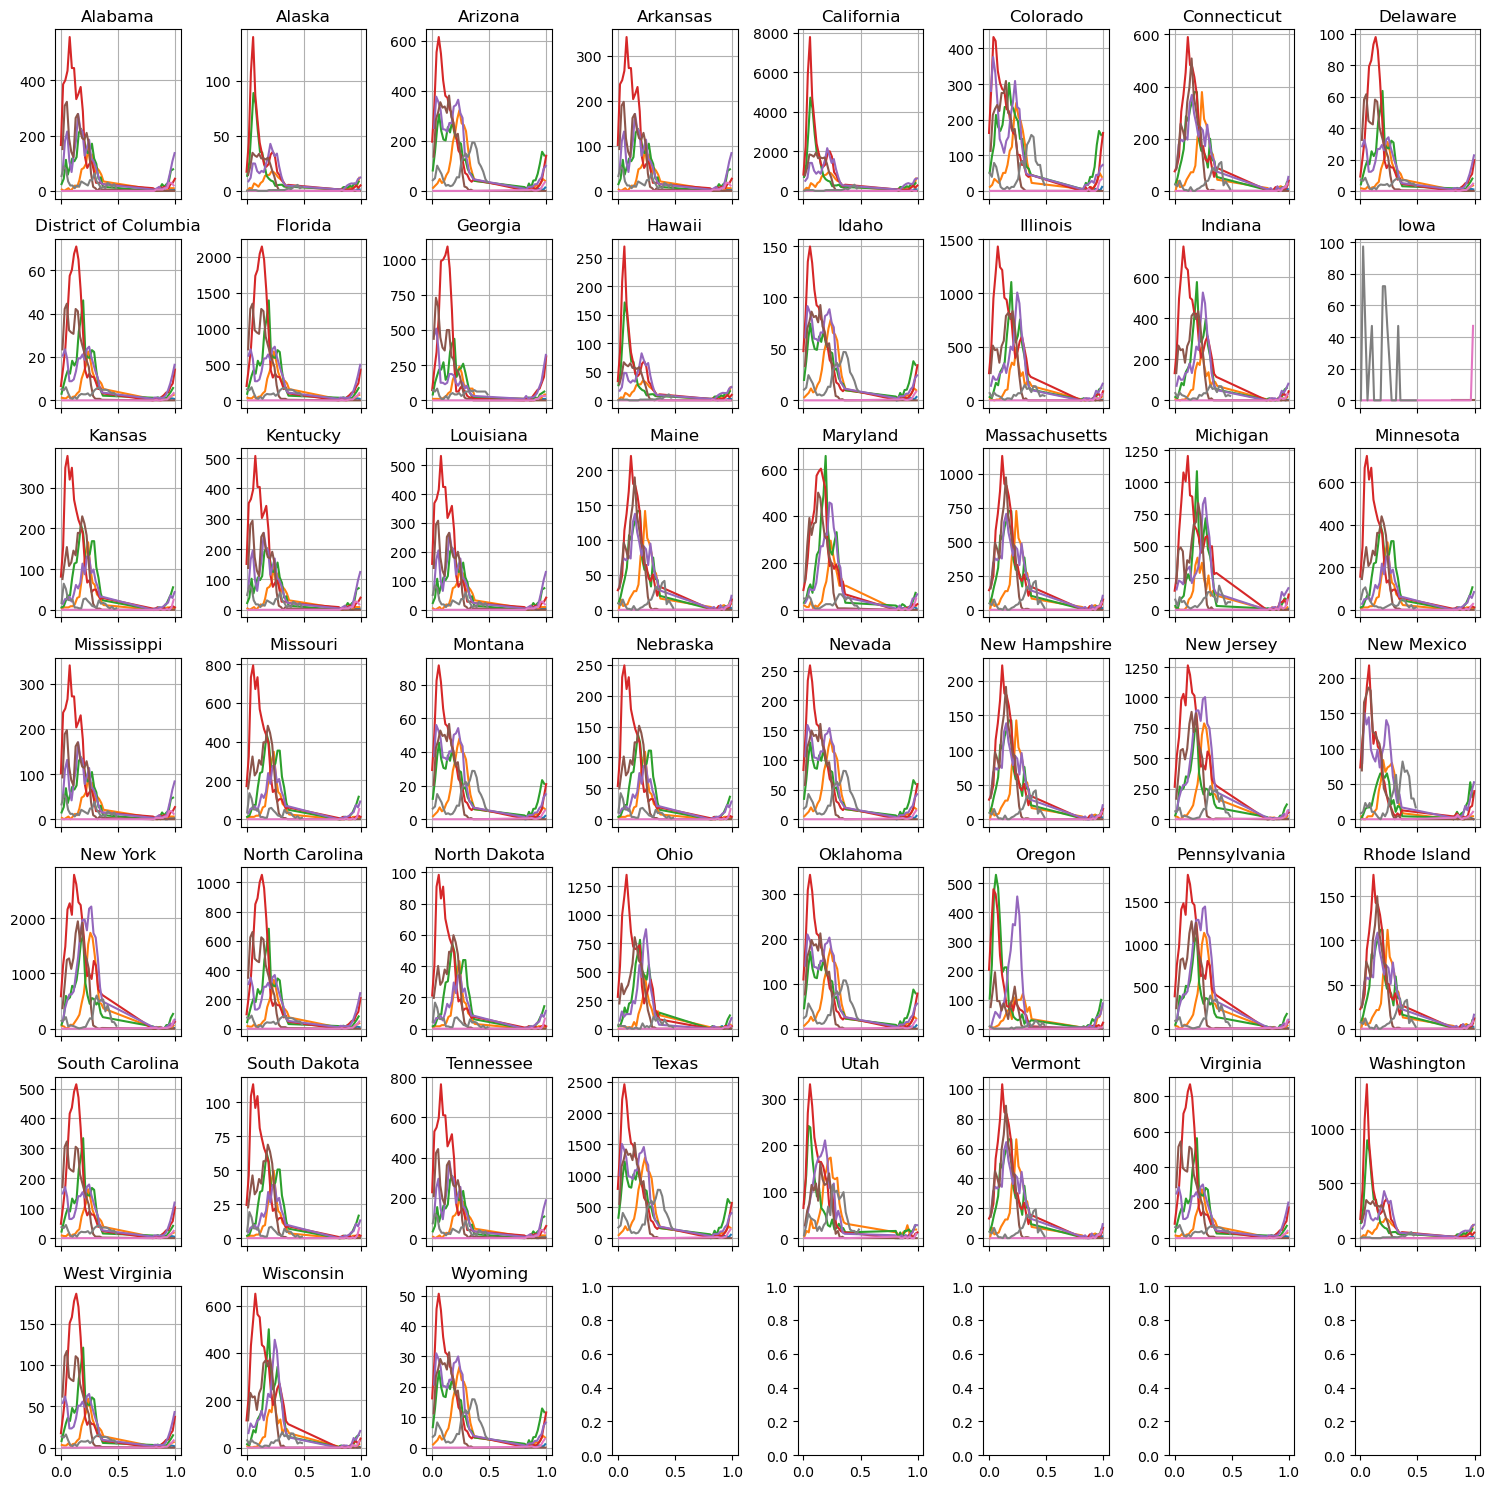

In [28]:
fig, axes = plt.subplots(7, 8, sharex=True, figsize=(15,15))
fluview_piv = df.pivot(columns='location_name', values='incidH', index=["fluseason", "fluseason_fraction"])
for idx, pl in enumerate(fluview_piv.columns):
    for year in fluview_piv.index.unique(level='fluseason'):
        ax = axes.flat[idx]
        ax.plot(fluview_piv.loc[year, pl])
        ax.set_title(pl)
    ax.grid()
fig.tight_layout()

In [17]:
flusetup.locations_df

,abbreviation,location_name,population,geoid,location_code
0,AL,Alabama,4903185.0,01000,01
1,AK,Alaska,731545.0,02000,02
2,AZ,Arizona,7278717.0,04000,04
3,AR,Arkansas,3017804.0,05000,05
4,CA,California,39512223.0,06000,06
5,CO,Colorado,5758736.0,08000,08
6,CT,Connecticut,3565287.0,09000,09
7,DE,Delaware,973764.0,10000,10
8,DC,District of Columbia,705749.0,11000,11
9,FL,Florida,21477737.0,12000,12


## Synthetic dataset from CSP

In [ ]:
assert False  # stop here when "Run All" is used in this notebook
import gempyor
folder = 'datasets/SMH_R1/'
col2keep = ['incidH_FluA', 'incidH_FluB']

Commands to sync Flu SMH R1 from s3 bucket
```bash
aws s3 sync s3://idd-inference-runs/USA-20220923T154311/model_output/ datasets/SMH_R1/SMH_R1_lowVac_optImm_2022 --exclude "*" --include "hosp*/final/*"
aws s3 sync s3://idd-inference-runs/USA-20220923T155228/model_output/ datasets/SMH_R1/SMH_R1_lowVac_pesImm_2022 --exclude "*" --include "hosp*/final/*"
aws s3 sync s3://idd-inference-runs/USA-20220923T160106/model_output/ datasets/SMH_R1/SMH_R1_highVac_optImm_2022 --exclude "*" --include "hosp*/final/*"
aws s3 sync s3://idd-inference-runs/USA-20220923T161418/model_output/ datasets/SMH_R1/SMH_R1_highVac_pesImm_2022 --exclude "*" --include "hosp*/final/*"
```
and take a humidity file from the config


In [ ]:
humid = pd.read_csv('datasets/SMH_R1/SMH_R1_lowVac_optImm_2022/r0s_ts_2022-2023.csv', index_col='date', parse_dates=True)

In [ ]:
maxfiles = -1
hosp_files = list(Path(str(folder)).rglob('*.parquet'))[:maxfiles]
df = gempyor.read_df(str(hosp_files[0]))

# To be pasted later
indexes = df[['date', 'geoid']]
full_df = df[['date', 'geoid']] # to
geoids = list(pd.concat([df[col2keep[0]], indexes], axis=1).pivot(values=col2keep[0], index='date', columns='geoid').columns)
dates = list(pd.concat([df[col2keep[0]], indexes], axis=1).pivot(values=col2keep[0], index='date', columns='geoid').index)

In [ ]:
df.columns

In [ ]:
incid_xarr = xr.DataArray(-1 * np.ones((len(hosp_files), 
                           len(col2keep),
                           len(full_df.date.unique()),
                           len(full_df.geoid.unique())
                          )), 
                         coords={'sample': np.arange(len(hosp_files)),'feature': col2keep, 'date': dates, 'place': geoids}, 
                         dims=["sample", "feature", "date", "place"])


for i, path_str in enumerate(hosp_files):
    df = gempyor.read_df(str(path_str))
    data = df[col2keep]
    for k, c in enumerate(col2keep):
        incid_xarr.loc[dict(sample=i, feature=c)] = pd.concat([data[c], indexes], axis=1).pivot(values=c, index='date', columns='geoid').to_numpy()
        

    data.columns = [n+f'_{i}' for n in col2keep]   
    full_df = pd.concat([full_df, data], axis=1)
    

print(int((incid_xarr<0).sum()), f' errors on {i} files')

In [ ]:
humid_st = np.dstack([humid.to_numpy()]*len(hosp_files))
#humid_st = humid_st[:, np.newaxis, :]
print(humid_st.shape)
covar_xarr = xr.DataArray(humid_st, 
                          coords={
                                  #'feature': ['R0Humidity'],
                                  'date': humid.index,
                                  'place': geoids,
                                  'sample': np.arange(len(hosp_files)),}, 
                          dims=[ "date", "place", "sample"]) #"feature",
covar_xarr = covar_xarr.expand_dims({"feature":['R0Humidity']})

### makes the dates of r0 and humidity match

In [ ]:
print(type(incid_xarr), incid_xarr.date[0], incid_xarr.date[-1] )
print(type(covar_xarr), covar_xarr.date[0], covar_xarr.date[-1])

In [ ]:
full_xarr = xr.concat([incid_xarr,covar_xarr], dim="feature", join="inner")

In [ ]:
grid = (1,4)
fig, axes = plt.subplots(grid[0], grid[1], sharex=True, sharey=True, figsize=(grid[1]*2,grid[0]*2))
for i, ax in enumerate(axes.flat):
    c = ['red', 'green', 'blue']
    place = full_xarr.get_index('place')[i]
    tp = full_xarr.sel(place=place)
    for k, val in enumerate(full_xarr.feature):
        ax.plot(tp.date, tp.sel(feature=val).T, c = c[k], lw = .1, alpha=.5)
        ax.plot(tp.date, tp.sel(feature=val).T.median(axis=1), 
                c = 'k',#'dark'+c[k], 
                lw = .5, 
                alpha=1)
    ax.grid()
    ax.set_title(place)
fig.autofmt_xdate()
fig.tight_layout()

In [ ]:
full_xarr_w = full_xarr.resample(date="W").sum()
full_xarr_w

In [ ]:
full_xarr_w_padded = full_xarr_w.pad({'date': (0, 17), 'place':(0,13)}, mode='constant', constant_values=0)
print(full_xarr_w_padded.shape)
full_xarr_w_padded.to_netcdf("datasets/synthetic/CSP_FluSMHR1_weekly_padded_4scn.nc")

## Dengue Trial

```python
def yw2date(row):
    year = int(row["year"])
    week = int(row["week"])
    date = "{}-{}-1".format(year, week)
    return datetime.strptime(date, "%Y-%W-%w")
df = pd.read_csv('dengue-thailand-province-week.csv')
df['year'] = df['date_sick_year']
df = df.drop('date_sick_year', axis=1)
df['date'] = df.apply(yw2date, axis=1)

## Cannot pivot there are duplicated entries:
df1 = df.set_index(['year', 'week', 'province'])
duplicated = np.where(df1.index.duplicated())
print(len(duplicated[0]), "duplicated index entries...")
print(duplicated[0])
print(df1.iloc[116065])
print(df1.loc[1999, 1, 10])

# pivot_table with aggregrate as mean
df = df.pivot_table(index='date', columns='province', values='cases', aggfunc='mean') # perhaps should be sum
fig, axes = plt.subplots(11, 7, sharex=True, sharey=True, figsize=(10,10))
for i, prov in enumerate(df.columns):
    ax = axes.flat[i]
    ax.plot(df[prov])
    ax.grid()
    ax.set_title(prov)
fig.autofmt_xdate()
fig.tight_layout()
```